# 1. Imports

In [1]:
import os
import sys
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Manejo de dependencias internas del proyecto
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(project_root)

from utils.get_llm_reviews import analyze_sentiment
from prompts.Sentiment_Analysis import system_prompt

# 2. Leo la data de reviews

La informacion a analizar, corresponde al sitio Mercado Libre.
La informacion contiene 1134 reviews de productos, de la categoria Celulares y Teléfonos.
El criterio utilizado para determinar si la review es positiva o negativa fue el ranking en estrellas obtenido en la review.

**Review Positiva:** 4 o 5 estrellas

**Review Negativa:** 1, 2 o 3 estrellas

In [2]:
csv_path = os.path.abspath(os.path.join(project_root, 'data', 'item_reviews.csv'))
df_reviews = pd.read_csv(csv_path)

Antes de comenzar, nos aseguramos que todos los registros tengan una review

# 3. Preparar la data

In [3]:
df_reviews["content"].isnull().sum()

18

Al existir 18 registros sin reviews, se eliminan ya que no se podrá hacer prediccion alguna sobre estos registros

In [4]:
df_reviews = df_reviews[-df_reviews["content"].isnull()].reset_index(drop=True)

Verificamos el balance de las clases a categorizar

In [5]:
df_reviews["sentiment"].value_counts("%")

sentiment
Positive    0.960573
Negative    0.039427
Name: proportion, dtype: float64

In [6]:
len(df_reviews)

1116

Si bien se seleccionaron 1116 reviews, de Mercado Libre, a fines del reporte solo utilizar el 20% del dataset para agilizar la velocidad del experimento.

Paar ser mas precisos con la realidad, el dataset de muestra tendra la mismsa distribucion de clases.

In [7]:
df_sample_random_reviews, _ = train_test_split(df_reviews, test_size=0.8, random_state=42, stratify=df_reviews['sentiment'])

df_sample_random_reviews = df_sample_random_reviews.reset_index(drop = True)

len(df_sample_random_reviews)

223

# 4. Obtenemos las predicciones

In [8]:
procesado = []

In [9]:
results_list = []

# Iterar sobre todas las filas del DataFrame
for i in range(len(df_sample_random_reviews)):
    if i not in procesado:
        try:
            review = df_sample_random_reviews.loc[i,"content"]
            sentiment = df_sample_random_reviews.loc[i,"sentiment"]
            predicted_sentiment = analyze_sentiment(review, system_prompt)
        
            result_dict = {
                "review": review,
                "actual_sentiment": sentiment,
                "predicted_sentiment": predicted_sentiment
            }
            results_list.append(result_dict)
            procesado.append(i)
            print("message {} from {}".format(i, len(df_sample_random_reviews)))
        except:
            print("no procesado {} from {}".format(i, len(df_sample_random_reviews)))
            procesado.append(i)
            pass

message 0 from 223
message 1 from 223
message 2 from 223
message 3 from 223
message 4 from 223
message 5 from 223
message 6 from 223
message 7 from 223
message 8 from 223
message 9 from 223
message 10 from 223
message 11 from 223
message 12 from 223
message 13 from 223
message 14 from 223
message 15 from 223
message 16 from 223
message 17 from 223
message 18 from 223
message 19 from 223
message 20 from 223
message 21 from 223
message 22 from 223
message 23 from 223
message 24 from 223
message 25 from 223
message 26 from 223
message 27 from 223
message 28 from 223
message 29 from 223
message 30 from 223
message 31 from 223
message 32 from 223
message 33 from 223
message 34 from 223
message 35 from 223
message 36 from 223
message 37 from 223
message 38 from 223
message 39 from 223
message 40 from 223
message 41 from 223
message 42 from 223
message 43 from 223
message 44 from 223
message 45 from 223
message 46 from 223
message 47 from 223
message 48 from 223
message 49 from 223
message 50

In [10]:
df_predictions = pd.DataFrame(results_list)
save_results_path = os.path.abspath(os.path.join(project_root, 'data', 'prediction_results.csv'))
df_predictions.to_csv(save_results_path)

# 5. Métricas

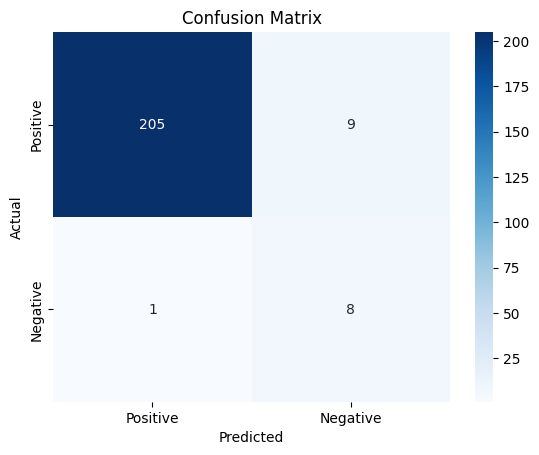

In [11]:
cm = confusion_matrix(df_predictions['actual_sentiment'], df_predictions['predicted_sentiment'], labels=["Positive", "Negative"])

# Visualizar matriz de confusión con seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
report = classification_report(df_predictions['actual_sentiment'],
                               df_predictions['predicted_sentiment'],
                               target_names=['Negative', 'Positive'])

In [13]:
print(report)

              precision    recall  f1-score   support

    Negative       0.47      0.89      0.62         9
    Positive       1.00      0.96      0.98       214

    accuracy                           0.96       223
   macro avg       0.73      0.92      0.80       223
weighted avg       0.97      0.96      0.96       223



# 6. Análisis de los resultados

Analizaremos ambos casos:

1. Reviews que son Positivas, pero el LLM predijo que son Negativas
2. Reviews que son Negativas, pero el LLM predijo que son Positivas

In [16]:
df_predictions[(df_predictions['actual_sentiment']=="Positive") & (df_predictions['predicted_sentiment']=="Negative")]

,review,actual_sentiment,predicted_sentiment
10,En relación precio calidad excelente. Aunque c...,Positive,Negative
17,"Bueno, falta que marque los km recorridos como...",Positive,Negative
42,"La verdad esperaba más,la batería no dura nada...",Positive,Negative
65,El cable no dice que es marca soul como la des...,Positive,Negative
69,"Muy buen producto, pero en la descripción decí...",Positive,Negative
82,"Pedi una devolución parcial del dinero, aún no...",Positive,Negative
88,"Una falla, se tilda con el sensor de luz y ten...",Positive,Negative
93,"Rapido, buena camara, bien la pantalla pero la...",Positive,Negative
205,Me gusto. Le falta más sonido cuando me llaman...,Positive,Negative


Como se puede observar, en este caso, las reviews son casos que, a pesar de haberlas calificado con 4 o 5 estrellas, el producto presenta oportunidades de mejora. Puede que estas reviews, no son lo suficientemente malas, como para tribuirle el ranking que finalmente le dieron al producto.

In [17]:
df_predictions[(df_predictions['actual_sentiment']=="Negative") & (df_predictions['predicted_sentiment']=="Positive")]

,review,actual_sentiment,predicted_sentiment
111,Mi experiencia luego de varias horas de prueba...,Negative,Positive


In [19]:
print(df_predictions.loc[111,"review"])

Mi experiencia luego de varias horas de prueba es la siguiente:.
- el router tiene que tener el nombre de fabrica para que el repetidor no falle.
- es preferible acercarse con el repetidor a la zona donde queres hacer llegar la señal (con muy poca señal la agarra y la aumenta) que ponerlo a mitad de camino entre el router y la zona a dar señal.
- anda bien si no tiene paredes o losas. Las distancias aproximadas son 12 mtrs sin interferencias, 8 mtrs con 1 interferencia, 5 mtrs con 2 interferencias, no pasa las tres interferencias. Saludos.


En este caso, la persona se muestra frustrada por la falla en la conectividad del dispositivo. Lo hizo saber tanto en el score del producto como en la review, claramente aqui el LLM falló.

# 7. Conclusiones

1. El modelo funciona muy bien, tiene un 96% de accuracy.
2. La baja precisión, en el caso de las reviews Negativas, se puede explicar por una mal criterio en la categorizacion de las reviews, es decir, no siempre el score que se le atribuye al producto, va correlacionado a una review acorde.
3. Es un buen LLM que sirve para identificar las reviews Positivas, alcanzando casi 100% de accuracy

# 8. Next steps / Mejoras propuestas

Para mejorar el score del LLM, se proponen las siguientes alternativas:

1. Seleccionar otro criterio para categorizar las reviews entre Positivas y Negativas.
2. Utilizar ejemplos de casos "edge", con el objetivo de proporcionarle mas informacion relevante al LLM.
3. Hacer fine tune del sobre un modelo base para poder ajustar los resultados.
